# The Clebsch system

From equation (5.21) in D'Haeseleer we have that

$$\mathbf{B}=\nabla \alpha \times \nabla \beta$$

We are here looking for a way to determine $\alpha$ and $\beta$, given $\mathbf{B}$. In order to easily validate the parallel advection, we will look for a $\mathbf{B}$ which

1. Does not have any variation in the $z$ coordinate
2. Varies in a simple way, so that a gaussian perturbation is easy to follow.

Further, we would like to describe this in a coordinate system where

* Makes $g_{ij}$ and $g^{kl}$ vary with $x$ (or $y$).
* We would like $g^{ij}$ and $g_{ij}$ to vary with $\alpha$ and $\beta$, so that the Christoffel symbols are non-zero.

# Initialization

In [1]:
%matplotlib notebook

import matplotlib
import numpy as np
import matplotlib.pyplot as plt

from collections import OrderedDict, deque

from sympy import init_printing
from sympy import symbols
from sympy import Eq, Derivative, Function
from sympy import sqrt
from sympy import solve, simplify
from sympy.solvers.pde import pdsolve
from sympy.utilities.lambdify import lambdify, implemented_function
from sympy import Rational as R
from IPython.display import display

init_printing()

In [2]:
title_size = 30 
plt.rc("font", size = 30)
plt.rc("axes", labelsize = 25, titlesize = title_size)
plt.rc("xtick", labelsize = 25)
plt.rc("ytick", labelsize = 25)
plt.rc("legend", fontsize = 30)
plt.rc("lines", linewidth = 2) 

In [3]:
s = symbols('s', real = True)
xi = symbols('xi', real = True)
x, y, z = symbols('x, y, z', real = True)
a, b, g = symbols('alpha, beta, gamma', real = True)
alpha = Function('alpha')(x,y,z)
beta  = Function('beta')(x,y,z)
gamma = Function('g')(x,y,z) # Looks like gamma is predefined
cart       = [x, y, z]
curvCoords = [a, b, g]
curvFuncs  = [alpha, beta, gamma]
bx, by, bz = symbols('B_x, B_y, B_z', real = True)
BElements  = [bx, by, bz]

In [4]:
def dot(a, b):
    """Returns the dot product of two vectors in cartesian coordinates"""
    
    return a[x]*b[x] + a[y]*b[y] + a[z]*b[z]

In [5]:
def cross(a, b):
    """Returns the cross product of two vectors in cartesian coordinates"""
    crossVec = OrderedDict([(x, a[y]*b[z] - a[z]*b[y]),
                            (y, a[z]*b[x] - a[x]*b[z]),
                            (z, a[x]*b[y] - a[y]*b[x])])
    return crossVec

In [6]:
def grad(func):
    """Returns the gradient in cartesian coordinates using diff"""
    gradVec = OrderedDict([(x, func.diff(x)),
                           (y, func.diff(y)),
                           (z, func.diff(z))])
    return gradVec

In [7]:
def matrixMul(A,B):
    """Returns the matrix multiplication between covariant and contravariant tensors"""
    M = OrderedDict.fromkeys(A)
    
    for firstCoord in A.keys():
        M[firstCoord] = OrderedDict.fromkeys(A)
        for secondCoord in A.keys():
            M[firstCoord][secondCoord] = 0
            for thridCoord in A.keys():
                M[firstCoord][secondCoord] += A[firstCoord][thridCoord]*B[thridCoord][secondCoord]
            M[firstCoord][secondCoord] = simplify(M[firstCoord][secondCoord])
            display((Eq(symbols('M_' + str(firstCoord) + '^' + str(secondCoord)), M[firstCoord][secondCoord])))
    
    return M

In [8]:
def printVec(vec, string=None):
    """Prints the vector components given the vector and a string to place on the LHS"""
    if string == None:
        string = ''
        separator = ''
    else:
        separator = "_"
    for coord in vec.keys():
        display(Eq(symbols(string + separator + str(coord)), vec[coord]))

In [9]:
def getMetricsContra(curvFuncsAsVec):
    """Returns the contravariant metric tensor the new coordinates described in cartesian coordinates"""
    G = OrderedDict()
    
    for firstCoord in curvFuncsAsVec.keys():
        G[firstCoord] = OrderedDict()
        firstFunc = curvFuncsAsVec[firstCoord]
        for secondCoord in curvFuncsAsVec.keys():
            secondFunc = curvFuncsAsVec[secondCoord]
            G[firstCoord][secondCoord] = dot(grad(firstFunc), grad(secondFunc))
            display(Eq(symbols('g^' + str(firstCoord) + '^' + str(secondCoord)) ,G[firstCoord][secondCoord]))
    
    return G

In [10]:
def getMetricsCov(curvFuncsAsVec, J=None):
    """
    Returns the covariant metric tensor the new coordinates described in cartesian coordinates.
    There are several ways of finding this, since the gradient is already implemented, we will use 
    equation (2.5.25) and (2.5.26) in D'Haeseleer.
    """
    if J == None:
        # Obtain Jacobian
        curvFunc = curvFuncsAsVec.values()
        J = getJacobian(list(curvFunc))
    
    coBasisVectors = OrderedDict.fromkeys(curvFuncsAsVec)
    # Deque is used for cyclic permutations
    coords = deque(curvFuncsAsVec.keys())
    for _ in range(len(cart)):
        coBasisVectors[coords[0]] = cross(grad(curvFuncsAsVec[coords[1]]), grad(curvFuncsAsVec[coords[2]]))
        for coord in coBasisVectors[coords[0]]:
            coBasisVectors[coords[0]][coord] *= J
        # Cyclic permutation (rigth rotation)
        coords.rotate(1)
    
    # Initialize the OrderedDict
    G = OrderedDict()
    
    for firstCoord in curvFuncsAsVec.keys():
        G[firstCoord] = OrderedDict()
        for secondCoord in curvFuncsAsVec.keys():
            G[firstCoord][secondCoord] = dot(coBasisVectors[firstCoord], coBasisVectors[secondCoord])
            display(Eq(symbols('g_' + str(firstCoord) + '_' + str(secondCoord)) ,G[firstCoord][secondCoord]))
    
    return G

In [11]:
def getJacobian(curvFuncs):
    """Returns the Jacobian (equation (2.5.26) in D'Haeseleer)"""
    J = R(1)/(dot(grad(curvFuncs[0]),cross(grad(curvFuncs[1]), grad(curvFuncs[2]))))

    return J

The Christoffel symbols reads

$$
\Gamma^i_{kl}=\frac{1}{2}g^{im}
\left(
\frac{\partial g_{mk}}{\partial x^l} + \frac{\partial g_{ml}}{\partial x^k} - \frac{\partial g_{kl}}{\partial x^m} \right)
$$

In [12]:
def getChristoffel(cov, con):
    """
    Returns the Christoffel symbol of second kind given the co- and contravariant components of the metric tensor
    """
    C = OrderedDict.fromkeys(con)
    
    for firstCoord in con.keys():
        C[firstCoord] = OrderedDict.fromkeys(con)
        for secondCoord in con.keys():
            C[firstCoord][secondCoord] = OrderedDict.fromkeys(con)
            for thirdCoord in con.keys():
                C[firstCoord][secondCoord][thirdCoord] = 0
                for fourthCoord in con.keys():
                    C[firstCoord][secondCoord][thirdCoord] +=\
                        R(1/2)*con[firstCoord][fourthCoord]\
                        *(\
                            cov[fourthCoord][secondCoord].diff(thirdCoord)\
                          + cov[fourthCoord][thirdCoord].diff(secondCoord)\
                          - cov[secondCoord][thirdCoord].diff(fourthCoord)\
                         )
                C[firstCoord][secondCoord][thirdCoord] = simplify(C[firstCoord][secondCoord][thirdCoord])
                display(Eq(symbols('Gamma^'+str(firstCoord)+'_'+str(secondCoord)+'_'+str(thirdCoord)),\
                           C[firstCoord][secondCoord][thirdCoord]))
    return C

In [13]:
def transformMetrics(m, r, cov=False):
    """Transform the metrics 'm' using a list of replacements 'r'"""
    
    if cov == False:
        binder = '^'
    else:
        binder = '_'    
    for firstCoord in m.keys():
        for secondCoord in m[firstCoord].keys():
            m[firstCoord][secondCoord] = simplify(m[firstCoord][secondCoord].subs(r))
            display(Eq(symbols('g' +binder+ str(firstCoord) +binder+ str(secondCoord)), m[firstCoord][secondCoord]))

    return m

# Pathlines of B

The pathlines are equal to the streamlines when the velocity does not vary with $t$. These lines will be the "rails" which the vectorfield is advected with if it is advected along the field lines.

The definition of a streamline is

$$
\frac{\text{d}\mathbf{x}_s(s)}{\text{d}s}\times\mathbf{u} = 0
$$

We are here only interested that the direction of the streamlines should be parallel with the magnetic field, so we will instead calculate

$$
\frac{\text{d}\mathbf{x}_s(s)}{\text{d}s}\times\mathbf{B} = 0
$$

We can assign a pathline $\mathbf{x}_s(s)$ (parametrized by $s$) of $\mathbf{B}$, and calculate $\mathbf{B}$ from that

## Specification of the pathlines

We now use

<span style="color:red"><span style="font-size:150%">Note: Manual insertion in cell below!</span></span>


 and 



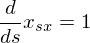

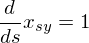

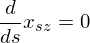

In [14]:
vecX_s = OrderedDict([
                    (x, s),
                    (y, s),
                    (z, 0*s),
                    ])

printVec(vecX_s, 'x_s')

print("\n and \n")
    
dds_vecX_s = OrderedDict.fromkeys(cart)
for coord in dds_vecX_s.keys():
    dds_vecX_s[coord] = vecX_s[coord].diff(s)
    display(Eq(Derivative(symbols("x_s_" + str(coord)), s) ,dds_vecX_s[coord]))

## Solve pathlines for B

Using

$$
\frac{\text{d}\mathbf{x}_s(s)}{\text{d}s}\times\mathbf{B} = \mathbf{p} = 0
$$

In [15]:
# Make the B vector
BVec = OrderedDict()
for coord, elem in zip(cart, BElements):
    BVec[coord] = elem

We find that

In [16]:
streamLineEqVec = cross(dds_vecX_s, BVec)
printVec(streamLineEqVec, 'p')

Solving $\mathbf{p}=0$ gives

In [17]:
eqs = []
for coord in streamLineEqVec.keys():
    eqs.append(Eq(streamLineEqVec[coord], 0))
    
sol = solve(eqs, [BVec[coord] for coord in BVec])
replacements = []
for elem in sol.keys():
    replacements.append((elem, sol[elem]))
    display(Eq(elem, sol[elem]))

The resulting streamlines can be seen below, after further specification of the system.

# B-field equations

Based on the streamlines, we will now specify the $\mathbf{B}$-field through specification of $\alpha$ and $\beta$ 

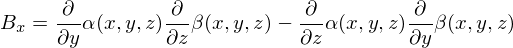

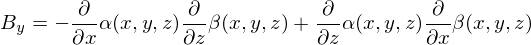

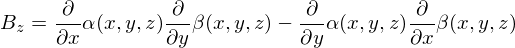

In [18]:
B = cross(grad(alpha),grad(beta))

printVec(B, 'B')

The equation above is a statement of the $\mathbf{B}$-vector in cartesian coordinates. From condition number 1 of the B-field above, we have that $B_i = B_i(x,y)$, meaning that $\alpha$ and $\beta$ can only vary linearly with $z$

## Solve the B-field for $\alpha$ and $\beta$

Unfortunately, sympy cannot currently (2015.12.10) solve sets of PDE.

```python
eqs = []
 for LHS, RHSkey in zip(BElements, B.keys()):
    eqs.append(Eq(LHS, B[RHSkey]))
 pdsolve(eqs)
```

However, MAPLE can (not succeeded in Mathematica), and one of the solutions for the equations above reads

<span style="color:red"><span style="font-size:150%">Note: Manual insertion in cell below!</span></span>

In [19]:
def getAlphaBeta(f1, f2, f1diff):
    """Returns alpha and beta"""
    alpha = f1
    beta  = (bx*z/f1diff) - (bz*x/f1diff) + f2
    display(Eq(a, alpha))
    display(Eq(b, beta))
    return alpha, beta

<span style="color:red"><span style="font-size:150%">Note: Manual insertion in cell below!</span></span>

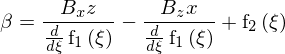

Using


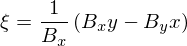

In [20]:
arg = (bx*y-by*x)/bx

f1  = Function('f_1')(xi)
f2  = Function('f_2')(xi)
f1diff = f1.diff(xi)

alpha, beta = getAlphaBeta(f1, f2, f1diff)

print("Using")
display(Eq(xi, arg))

## Specifying the equations for determining $\alpha$ and $\beta$

We choose

<span style="color:red"><span style="font-size:150%">Note: Manual insertion in cell below!</span></span>

In [21]:
# Just chosing the functions to something simple
f1 = arg
f2 = arg**2 # Square this to make sure g^ab is non-zero
f1diff = 1

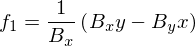

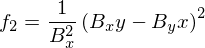

In [22]:
display(Eq(symbols('f_1'), f1))
display(Eq(symbols('f_2'), f2))

So that

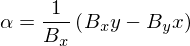

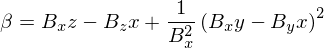

In [23]:
alpha, beta = getAlphaBeta(f1, f2, f1diff)

## Specifying the coefficients for determining $\alpha$ and $\beta$

From solving for the pathlines, we have

In [24]:
display(Eq(replacements[0][0], replacements[0][1]))
display(Eq(replacements[1][0], replacements[1][1]))

Which gives

In [25]:
alpha = alpha.subs(replacements)
beta = beta.subs(replacements)

display(simplify(Eq(a, alpha)))
display(simplify(Eq(b, beta)))

$$
\nabla \alpha \times \nabla \beta
$$
now yields

<span style="color:red"><span style="font-size:150%">Note: Check solution below!</span></span>

In [26]:
B = cross(grad(alpha),grad(beta))

printVec(B, 'B')

## Calculate $\gamma$

From D'Haeseleer equation (5.3.9) we have
$$
\mathbf{b}\cdot\nabla\gamma = 1
$$
which means that
$$
\mathbf{B}\cdot\nabla\gamma = B
$$

We can use this to solve for $\gamma$.

As our $\mathbf{B}$-field reads

In [27]:
BSpecified = cross(grad(alpha),grad(beta))
printVec(BSpecified, 'B')

We get the following equation to solve

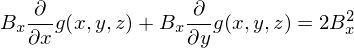

In [28]:
gammaEq = Eq(dot(BSpecified,grad(gamma)), dot(BSpecified,BSpecified))
display(gammaEq)

Unfortunately sympy currently (2015.12.10) throws the error

"Right now only partial differential equations of two variables are supported"

When trying run the following code
```python
print("Solving this gives")
gamma = pdsolve(eq)
display(gamma)
```
However, the equation is of such form that the solution of the equation above is the same for $g(x,y)$ and $g(x,y,z)$ up to a constant function $F(z)$. This means that the following is a solution

In [29]:
gammaTempF = Function('g')(x,y)
eq = Eq(dot(BSpecified,grad(gammaTempF)), dot(BSpecified,BSpecified))
gammaTemp = pdsolve(eq)

gammaTempRHS = gammaTemp.rhs
display(Eq(gammaTempF, gammaTempRHS))

Where $F$ is also a function of $z$.

## Specifying equations for determining $\gamma$

We are now choosing the function

<span style="color:red"><span style="font-size:150%">Note: Manual insertion in cell below!</span></span>

In [30]:
f1 = bx*(x-y)**2 + bx*(x-y)
f2 = z
f = f1+f2
gamma = bx*(x+y) + f

In [31]:
display(Eq(symbols('F'), f))

Which gives

In [32]:
display(Eq(g,gamma))

## The set of equations

In [33]:
# Check if a solution is found
check = simplify(Eq(gammaEq.rhs, gammaEq.lhs.subs([(Function('g')(x,y,z), gamma)]).doit()))
if check != True:
    display(check)
    raise RuntimeError ("Gamma is not a solution")

We now have the set of equations

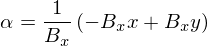

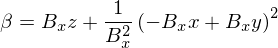

In [34]:
# Setting the functions
curvFuncsBUnspecified = [alpha, beta, gamma]
invCoordBUnspecified = OrderedDict.fromkeys(curvCoords)
for coord, func in zip(invCoordBUnspecified.keys(), curvFuncsBUnspecified):
    invCoordBUnspecified[coord] = func
    display(Eq(coord, func))

# Metric tensor equations and Christoffel symbols

We would now calculate the metric tensors, and check that the Christoffel symbols are non-zero.

Unspecified, the metric tensor gives

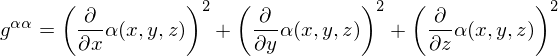

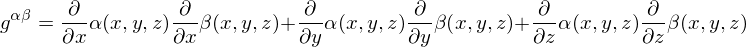

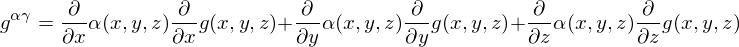

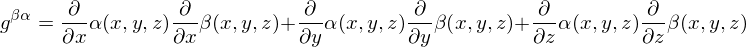

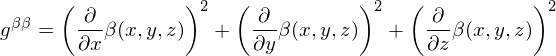

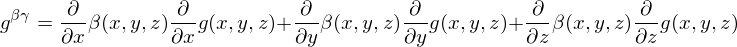

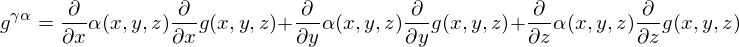

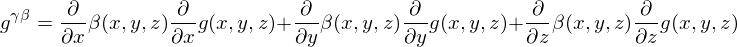

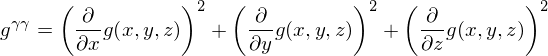

In [35]:
# Make a vector out of curvFuncs
curvFuncsAsVec = OrderedDict(zip(curvCoords, curvFuncs))
G = getMetricsContra(curvFuncsAsVec)

Using the specified functions, we get

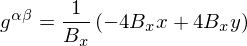

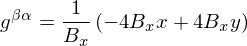

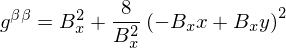

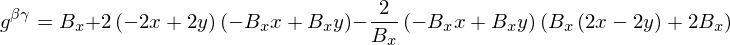

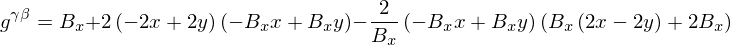

In [36]:
curvFuncsBUnspecifiedAsVec = OrderedDict(zip(curvCoords, curvFuncsBUnspecified))
GBUnspecified = getMetricsContra(curvFuncsBUnspecifiedAsVec)

# Specifying the undetermined coefficients in B

We now set

<span style="color:red"><span style="font-size:150%">Note: Manual insertion in cell below!</span></span>

In [37]:
replacement = [(bx, 1)]
display(Eq(replacement[0][0], replacement[0][1]))
invCoordBSpecified = OrderedDict.fromkeys(curvCoords)

This gives the coordinates

In [38]:
curvFuncsBSpecified = []
eqs = []
for coord in invCoordBSpecified.keys():
    invCoordBSpecified[coord] = simplify(invCoordBUnspecified[coord].subs(replacement))
    eqs.append(Eq(coord, invCoordBSpecified[coord]))
    curvFuncsBSpecified.append(invCoordBSpecified[coord])

    
printVec(invCoordBSpecified)

With the inverse

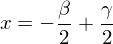

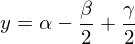

In [39]:
sol = solve(eqs, cart)
replaceToNewSystem = []
for coord, RHS in zip(cart, sol[0]):
    replaceToNewSystem.append((coord, RHS))
    display(Eq(coord, RHS))

### The resulting jacobian

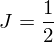

In [40]:
J = getJacobian(list(curvFuncsBSpecified))
display(Eq(symbols('J'), J))

### The resulting contravariant metric coefficients

In [41]:
curvFuncsBSpecifiedAsVec = OrderedDict(zip(curvCoords, curvFuncsBSpecified))
GBSpecified = getMetricsContra(curvFuncsBSpecifiedAsVec)

Written in our new coordinate system

In [42]:
mCon = transformMetrics(GBSpecified, replaceToNewSystem)

### The resulting covariant metric coefficients

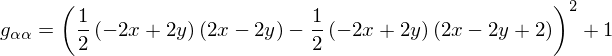

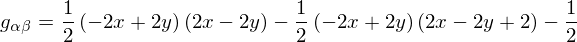

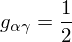

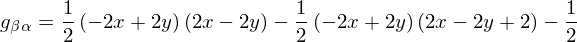

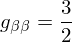

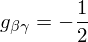

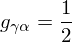

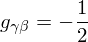

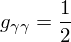

In [43]:
curvFuncsBSpecifiedAsVec = OrderedDict(zip(curvCoords, curvFuncsBSpecified))
GBSpecifiedCov = getMetricsCov(curvFuncsBSpecifiedAsVec, J)

Written in our new coordinate system

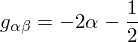

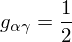

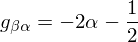

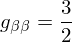

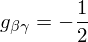

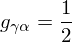

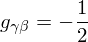

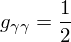

In [44]:
mCov = transformMetrics(GBSpecifiedCov, replaceToNewSystem, cov=True)

### Checking the result
We should have that
$$g_{ij}g^{jk}=\delta_i^k$$

In [45]:
I = matrixMul(GBSpecifiedCov, GBSpecified)

### The resulting Christoffel symbols

In [46]:
C = getChristoffel(cov = GBSpecifiedCov, con = GBSpecified)

### The resulting stream lines

<IPython.core.display.Javascript object>


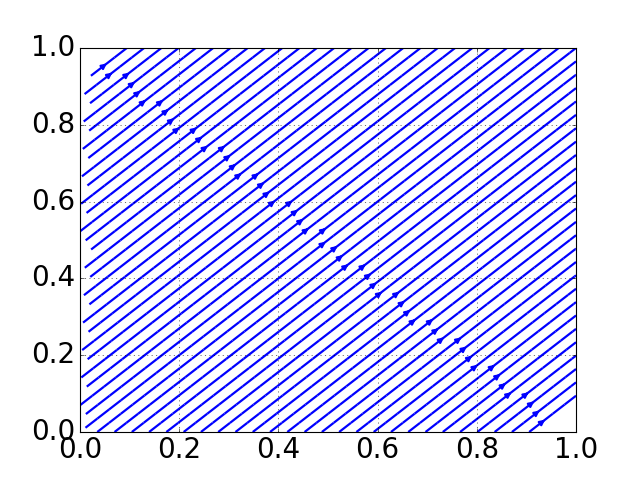

In [47]:
# Complex number denotes number of points
Y, X = np.mgrid[0:1:100j, 0:1:100j]
# Specifying the vector
U = V = X
fig1, (ax1) = plt.subplots(ncols=1)
ax1.grid()
sp = ax1.streamplot(X, Y, U, V)

## Concluding remarks

The sytem found here will exercise all the Christoffel symbols (although $\Gamma^\gamma_{\alpha\alpha}=0$). 

If we interchange
$$\alpha \to -\beta$$
(minus due to the cross product $\nabla \alpha \times \nabla \beta$) and
$$\beta \to \alpha$$
we will get the same system, but we will exercise other derivatives.

# Copyable when verifying in BOUT++

In [48]:
def printBOUTinpCon(mCon, replacements, inpReplacements):
    for firstCoord in mCon.keys():
        for secondCoord in mCon[firstCoord].keys():
            c1 = str(firstCoord)
            c2 = str(secondCoord)
            formula = str(mCon[firstCoord][secondCoord])
            for replacement in replacements:
                c1 = c1.replace(replacement[0], replacement[1])
                c2 = c2.replace(replacement[0], replacement[1])
            for replacement in inpReplacements:
                formula = formula.replace(replacement[0], replacement[1])
            print("g{0}{1} = {2}".format(c1,c2,formula))

In [49]:
def printBOUTinpCov(mCov, replacements, inpReplacements):
    for firstCoord in mCov.keys():
        for secondCoord in mCov[firstCoord].keys():
            c1 = str(firstCoord)
            c2 = str(secondCoord)
            formula = str(mCov[firstCoord][secondCoord])
            for replacement in replacements:
                c1 = c1.replace(replacement[0], replacement[1])
                c2 = c2.replace(replacement[0], replacement[1])
            for replacement in inpReplacements:
                formula = formula.replace(replacement[0], replacement[1])
            print("g_{0}{1} = {2}".format(c1,c2,formula))

In [50]:
def printChristoffel(C, replacements):
    for firstCoord in C.keys():
        for secondCoord in C[firstCoord].keys():
            for thirdCoord in C[firstCoord][secondCoord].keys():
                c1 = str(firstCoord)
                c2 = str(secondCoord)
                c3 = str(thirdCoord)
                for replacement in replacements:
                    c1 = c1.replace(replacement[0], replacement[1])
                    c2 = c2.replace(replacement[0], replacement[1])
                    c3 = c3.replace(replacement[0], replacement[1])
                symb = "G{0}_{1}{2}".format(c1, c2, c3)
                print("{0} = {1}".format(symb ,C[firstCoord][secondCoord][thirdCoord]))

## Using the original system

In [51]:
replacements = [("alpha","1"), ("beta","2"), ("gamma","3")]
inpReplacements = [("**", "^"), ("alpha", "geom:xl")]

The covariant metric tensor is inserted in the BOUT.inp file

In [52]:
printBOUTinpCon(mCon, replacements, inpReplacements)

g11 = 2
g12 = 4*geom:xl
g13 = 4*geom:xl - 2
g21 = 4*geom:xl
g22 = 8*geom:xl^2 + 1
g23 = 8*geom:xl^2 - 4*geom:xl + 1
g31 = 4*geom:xl - 2
g32 = 8*geom:xl^2 - 4*geom:xl + 1
g33 = 8*geom:xl^2 - 8*geom:xl + 5


The contravariant metric tensor is inserted in the BOUT.inp file

In [53]:
printBOUTinpCov(mCov, replacements, inpReplacements)

g_11 = 4*geom:xl^2 + 1
g_12 = -2*geom:xl - 1/2
g_13 = 1/2
g_21 = -2*geom:xl - 1/2
g_22 = 3/2
g_23 = -1/2
g_31 = 1/2
g_32 = -1/2
g_33 = 1/2


The Christoffel symbols can be checked by saving the Christoffel symbols into an output file in a BOUT++ run, and compare the output with the Christoffel symbols found here.

In [54]:
printChristoffel(C, replacements)

G1_11 = 0
G1_12 = 0
G1_13 = 0
G1_21 = 0
G1_22 = 0
G1_23 = 0
G1_31 = 0
G1_32 = 0
G1_33 = 0
G2_11 = -2
G2_12 = 0
G2_13 = 0
G2_21 = 0
G2_22 = 0
G2_23 = 0
G2_31 = 0
G2_32 = 0
G2_33 = 0
G3_11 = -2
G3_12 = 0
G3_13 = 0
G3_21 = 0
G3_22 = 0
G3_23 = 0
G3_31 = 0
G3_32 = 0
G3_33 = 0


## Using the $\alpha \to -\beta$ and $\beta \to \alpha$ system